In [ ]:
pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, Concatenate,Dropout
from tensorflow.keras.optimizers import Adam
from joblib import dump, load
import joblib
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import datetime

In [ ]:
df = pd.read_csv("datasetFixMyRide.csv")

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gejala1             550 non-null    object
 1   gejala2             550 non-null    object
 2   gejala3             550 non-null    object
 3   jenis_motor         550 non-null    object
 4   merk_motor          550 non-null    object
 5   tahun               550 non-null    int64 
 6   km_motor            550 non-null    int64 
 7   pernah_servis       550 non-null    object
 8   permasalahan_motor  550 non-null    object
 9   solusi              550 non-null    object
dtypes: int64(2), object(8)
memory usage: 43.1+ KB
None


In [ ]:
df.head()

,gejala1,gejala2,gejala3,jenis_motor,merk_motor,tahun,km_motor,pernah_servis,permasalahan_motor,solusi
0,kebocoran oli,suara aneh,sulit distarter,matic,yamaha,2019,15000,ya,masalah mesin,perbaiki kebocoran oli dan ganti starter yang ...
1,hilangnya tenaga,asap berlebihan,mesin mati mendadak,matic,honda,2020,18000,ya,masalah sistem bahan bakar,bersihkan injektor bahan bakar dan ganti filte...
2,rem berderit,idling tidak teratur,tidak ada,gigi,suzuki,2018,20000,ya,masalah rem,ganti bantalan rem dan lumasi komponen rem
3,bau aneh dari knalpot,mesin terlalu panas,konsumsi bahan bakar tinggi,gigi,yamaha,2017,22000,tidak,masalah knalpot,periksa dan perbaiki sistem pembuangan
4,kesulitan berpindah gigi,getaran mesin,suara berisik dari mesin,gigi,honda,2019,25000,ya,masalah transmisi,periksa dan ganti cairan transmisi atau lakuka...


In [ ]:
df.describe()

,tahun,km_motor
count,550.000000,550.000000
mean,2018.505455,21754.545455
std,1.962064,3815.380540
min,2015.000000,10000.000000
25%,2017.000000,19000.000000
50%,2019.000000,22000.000000
75%,2020.000000,24000.000000
max,2022.000000,30000.000000


In [ ]:
df.isnull().sum()

gejala1               0
gejala2               0
gejala3               0
jenis_motor           0
merk_motor            0
tahun                 0
km_motor              0
pernah_servis         0
permasalahan_motor    0
solusi                0
dtype: int64

In [ ]:
df['gejala1'].value_counts()

oli berlebihan                 68
kopling terlalu keras          58
kopling terlalu lembek         52
suara mendesis dari knalpot    45
suara aneh                     40
getaran berlebihan             38
rem berderit                   38
suara mendesis                 37
kebocoran oli                  36
bau aneh dari knalpot          26
konsumsi bahan bakar tinggi    14
hilangnya tenaga               14
kopling selip                  14
kesulitan berpindah gigi       14
suara aneh dari knalpot        14
suara mendesis dari mesin      14
oli berkurang drastis          10
bau gas berlebihan              8
rem tidak pakem                 6
suara aneh dari mesin           3
kondisi mesin baik              1
Name: gejala1, dtype: int64

In [ ]:
df['gejala2'].value_counts()

suara mendesis               73
kesulitan berpindah gigi     60
idling tidak teratur         55
asap berlebihan              53
rem tidak pakem              42
suara gesekan                39
suara aneh                   32
getaran pada setir           31
bau gas berlebihan           25
suara mendesis dari mesin    25
getaran berlebihan           18
kopling terlalu keras        16
getaran mesin                14
mesin terlalu panas          14
bau aneh dari knalpot        11
rem keras                    10
suara aneh dari mesin        10
akselerasi mendadak          10
rem responsif                 4
rem berderit                  4
suara normal                  1
mesin mati mendadak           1
sulit distarter               1
kopling terlalu lembek        1
Name: gejala2, dtype: int64

In [ ]:
df['gejala3'].value_counts()

sulit distarter                156
tidak bisa berakselerasi       118
mesin mati mendadak             89
tidak ada                       76
mesin terlalu panas             54
kesulitan berpindah gigi        16
konsumsi bahan bakar tinggi     14
suara berisik dari mesin        14
bau aneh dari knalpot            6
bau gas berlebihan               6
kesulitan memulai                1
Name: gejala3, dtype: int64

In [ ]:
df['jenis_motor'].value_counts()

matic    276
gigi     274
Name: jenis_motor, dtype: int64

In [ ]:
df['merk_motor'].value_counts()

yamaha    197
honda     179
suzuki    174
Name: merk_motor, dtype: int64

In [ ]:
df['pernah_servis'].value_counts()

ya       302
tidak    248
Name: pernah_servis, dtype: int64

In [ ]:
X_numerical = df[['tahun', 'km_motor']]
X_categorical = df[['gejala1', 'gejala2', 'gejala3', 'pernah_servis', 'merk_motor', 'jenis_motor']]
y = df['permasalahan_motor']

In [ ]:
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

In [ ]:
label_encoder_tahun = LabelEncoder()
label_encoder_km_motor = LabelEncoder()
label_encoder_gejala1 = LabelEncoder()
label_encoder_gejala2 = LabelEncoder()
label_encoder_gejala3 = LabelEncoder()
label_encoder_pernah_servis = LabelEncoder()
label_encoder_merk_motor = LabelEncoder()
label_encoder_jenis_motor = LabelEncoder()

label_encoder_tahun.fit(df['tahun'])
label_encoder_km_motor.fit(df['km_motor'])
label_encoder_gejala1.fit(df['gejala1'])
label_encoder_gejala2.fit(df['gejala2'])
label_encoder_gejala3.fit(df['gejala3'])
label_encoder_pernah_servis.fit(df['pernah_servis'])
label_encoder_merk_motor.fit(df['merk_motor'])
label_encoder_jenis_motor.fit(df['jenis_motor'])

LabelEncoder()

In [ ]:
joblib.dump(label_encoder_tahun, 'label_encoder_tahun.joblib')
joblib.dump(label_encoder_km_motor, 'label_encoder_km_motor.joblib')
joblib.dump(label_encoder_gejala1, 'label_encoder_gejala1.joblib')
joblib.dump(label_encoder_gejala2, 'label_encoder_gejala2.joblib')
joblib.dump(label_encoder_gejala3, 'label_encoder_gejala3.joblib')
joblib.dump(label_encoder_pernah_servis, 'label_encoder_pernah_servis.joblib')
joblib.dump(label_encoder_merk_motor, 'label_encoder_merk_motor.joblib')
joblib.dump(label_encoder_jenis_motor, 'label_encoder_jenis_motor.joblib')

['label_encoder_jenis_motor.joblib']

In [ ]:
X_categorical.loc[:, 'gejala1'] = label_encoder_gejala1.transform(X_categorical['gejala1'])
X_categorical.loc[:, 'gejala2'] = label_encoder_gejala2.transform(X_categorical['gejala2'])
X_categorical.loc[:, 'gejala3'] = label_encoder_gejala3.transform(X_categorical['gejala3'])
X_categorical.loc[:, 'pernah_servis'] = label_encoder_pernah_servis.transform(X_categorical['pernah_servis'])
X_categorical.loc[:, 'merk_motor'] = label_encoder_merk_motor.transform(X_categorical['merk_motor'])
X_categorical.loc[:, 'jenis_motor'] = label_encoder_jenis_motor.transform(X_categorical['jenis_motor'])

<ipython-input-23-646e801cb6dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_categorical.loc[:, 'gejala1'] = label_encoder_gejala1.transform(X_categorical['gejala1'])
<ipython-input-23-646e801cb6dd>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_categorical.loc[:, 'gejala1'] = label_encoder_gejala1.transform(X_categorical['gejala1'])
<ipython-input-23-646e801cb6dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [ ]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_categorical_encoded = encoder.fit_transform(X_categorical)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

In [ ]:
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [ ]:
X_combined = np.concatenate([X_numerical_scaled, X_categorical_encoded], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.25, random_state=42)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [ ]:
def build_model():
    num_actual_classes_expected = len(np.unique(y_encoded))
    input_dim = X_train.shape[1]

    model = Sequential()
    model.add(Dense(450, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_actual_classes_expected, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model = build_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.25, callbacks=[early_stopping])


Epoch 1/100
10/10 [==============================] - 1s 29ms/step - loss: 2.1755 - accuracy: 0.2071 - val_loss: 2.0483 - val_accuracy: 0.3107
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 1.9301 - accuracy: 0.2848 - val_loss: 1.7874 - val_accuracy: 0.5146
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 1.7013 - accuracy: 0.4919 - val_loss: 1.5290 - val_accuracy: 0.7573
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 1.4123 - accuracy: 0.5955 - val_loss: 1.2852 - val_accuracy: 0.7767
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 1.1909 - accuracy: 0.6634 - val_loss: 1.0837 - val_accuracy: 0.7767
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 1.0204 - accuracy: 0.7120 - val_loss: 0.9205 - val_accuracy: 0.8058
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8431 - accuracy: 0.7476 - val_loss: 0.8118 - val_accuracy: 0.8252
Epoch 8/100


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

5/5 [==============================] - 0s 3ms/step - loss: 0.2211 - accuracy: 0.9348
Test Loss: 0.2211
Test Accuracy: 0.9348


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder_y.inverse_transform(y_test)
y_pred_classes_original = label_encoder_y.inverse_transform(y_pred_classes)
print('\nClassification Report:')
print(classification_report(y_test_original, y_pred_classes_original))

5/5 [==============================] - 0s 3ms/step

Classification Report:
                            precision    recall  f1-score   support

           masalah knalpot       0.89      1.00      0.94        17
             masalah mesin       0.93      0.95      0.94        43
         masalah pendingin       0.67      0.50      0.57         4
               masalah rem       1.00      0.80      0.89         5
masalah sistem bahan bakar       0.96      0.96      0.96        26
         masalah transmisi       0.95      0.93      0.94        43

                  accuracy                           0.93       138
                 macro avg       0.90      0.86      0.88       138
              weighted avg       0.93      0.93      0.93       138



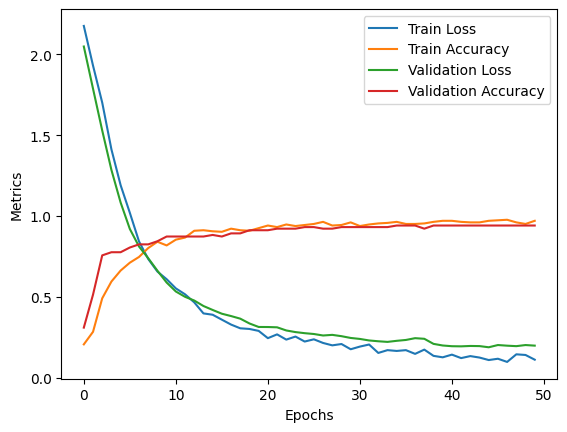

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [ ]:
model.save('bengkel_model.h5')

joblib.dump(label_encoder_tahun, 'label_encoder_tahun.joblib')
joblib.dump(label_encoder_km_motor, 'label_encoder_km_motor.joblib')
joblib.dump(label_encoder_gejala1, 'label_encoder_gejala1.joblib')
joblib.dump(label_encoder_gejala2, 'label_encoder_gejala2.joblib')
joblib.dump(label_encoder_gejala3, 'label_encoder_gejala3.joblib')
joblib.dump(label_encoder_pernah_servis, 'label_encoder_pernah_servis.joblib')
joblib.dump(label_encoder_merk_motor, 'label_encoder_merk_motor.joblib')
joblib.dump(label_encoder_jenis_motor, 'label_encoder_jenis_motor.joblib')
joblib.dump(encoder, 'encoder.joblib')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['encoder.joblib']

In [ ]:
loaded_model = load_model('bengkel_model.h5')
label_encoder_tahun = joblib.load('label_encoder_tahun.joblib')
label_encoder_km_motor = joblib.load('label_encoder_km_motor.joblib')
label_encoder_gejala1 = joblib.load('label_encoder_gejala1.joblib')
label_encoder_gejala2 = joblib.load('label_encoder_gejala2.joblib')
label_encoder_gejala3 = joblib.load('label_encoder_gejala3.joblib')
label_encoder_pernah_servis = joblib.load('label_encoder_pernah_servis.joblib')
label_encoder_merk_motor = joblib.load('label_encoder_merk_motor.joblib')
label_encoder_jenis_motor = joblib.load('label_encoder_jenis_motor.joblib')
encoder = joblib.load('encoder.joblib')
scaler = joblib.load('scaler.joblib')


In [ ]:
user_input_data = {
    'gejala1': 'kebocoran oli',
    'gejala2': 'suara aneh',
    'gejala3': 'sulit distarter',
    'jenis_motor': 'matic',
    'merk_motor': 'yamaha',
    'tahun': 2019,
    'km_motor': 15000,
    'pernah_servis': 'ya'
}

user_input_df = pd.DataFrame([user_input_data])
user_input_df['gejala1'] = label_encoder_gejala1.transform(user_input_df['gejala1'])
user_input_df['gejala2'] = label_encoder_gejala2.transform(user_input_df['gejala2'])
user_input_df['gejala3'] = label_encoder_gejala3.transform(user_input_df['gejala3'])
user_input_df['pernah_servis'] = label_encoder_pernah_servis.transform(user_input_df['pernah_servis'])
user_input_df['merk_motor'] = label_encoder_merk_motor.transform(user_input_df['merk_motor'])
user_input_df['jenis_motor'] = label_encoder_jenis_motor.transform(user_input_df['jenis_motor'])

X_categorical_encoded = encoder.transform(user_input_df[['gejala1', 'gejala2', 'gejala3', 'pernah_servis', 'merk_motor', 'jenis_motor']])

numerical_features = ['tahun', 'km_motor']
X_numerical_scaled = scaler.transform(user_input_df[numerical_features])

user_input_combined = np.concatenate([X_numerical_scaled, X_categorical_encoded], axis=1)

predictions = loaded_model.predict(user_input_combined)
predicted_class = np.argmax(predictions)
confidence = predictions[0][predicted_class]
predicted_class_label = label_encoder_y.inverse_transform([predicted_class])

print(f"Predicted Class: {predicted_class_label[0]}")
print(f"Confidence: {confidence:.4f}")

1/1 [==============================] - 0s 67ms/step
Predicted Class: masalah mesin
Confidence: 0.9971


In [ ]:
user_input_data = {
    'gejala1': 'hilangnya tenaga',
    'gejala2': 'asap berlebihan',
    'gejala3': 'mesin mati mendadak',
    'jenis_motor': 'matic',
    'merk_motor': 'honda',
    'tahun': 2020,
    'km_motor': 18000,
    'pernah_servis': 'ya'
}

user_input_df = pd.DataFrame([user_input_data])
user_input_df['gejala1'] = label_encoder_gejala1.transform(user_input_df['gejala1'])
user_input_df['gejala2'] = label_encoder_gejala2.transform(user_input_df['gejala2'])
user_input_df['gejala3'] = label_encoder_gejala3.transform(user_input_df['gejala3'])
user_input_df['pernah_servis'] = label_encoder_pernah_servis.transform(user_input_df['pernah_servis'])
user_input_df['merk_motor'] = label_encoder_merk_motor.transform(user_input_df['merk_motor'])
user_input_df['jenis_motor'] = label_encoder_jenis_motor.transform(user_input_df['jenis_motor'])

X_categorical_encoded = encoder.transform(user_input_df[['gejala1', 'gejala2', 'gejala3', 'pernah_servis', 'merk_motor', 'jenis_motor']])
numerical_features = ['tahun', 'km_motor']
X_numerical_scaled = scaler.transform(user_input_df[numerical_features])

user_input_combined = np.concatenate([X_numerical_scaled, X_categorical_encoded], axis=1)

predictions = loaded_model.predict(user_input_combined)
predicted_class = np.argmax(predictions)
confidence = predictions[0][predicted_class]
predicted_class_label = label_encoder_y.inverse_transform([predicted_class])

print(f"Predicted Class: {predicted_class_label[0]}")
print(f"Confidence: {confidence:.4f}")


1/1 [==============================] - 0s 21ms/step
Predicted Class: masalah sistem bahan bakar
Confidence: 0.9985
